<a href="https://colab.research.google.com/github/andyPandy1337/yatzee-sims/blob/master/Yahtzee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Log

**20190225** - The final bugs in the re-written implementation are now eliminated. The game runs as it should with a very simple player strategy.


**20190224** - Logic has been re-written in a way that should help to evaulate more strategies in the future. THe player class is now more independent and "makes its own decisions". It is still not fully functioning and the scoring seems to be a bit off.


## List of improvments
  
- ~~The scoring seems broken somehow. The player tries to play stuff he should not play.~~˙
- ~~Data formatting seems to be a bit inconsistent, could that be a problem?~~

# Yatzee game simulator

Goal: Be able to evaluate different yatzee game strategies with the help of simulations.

## Yatzee game flow

1. The player rolls 5 die
2. The player selects which die to keep, and which ones to discard. This is repeated maximium 2 times.
3. The player selects which way to "score" with die set, based on the the scores available. (see below for scores)
4. Based on the selection, the user gets a score for a given selection. This score then becomes unavailable for future scores
 
### Scores

- Ones - Sixes : Sum of the ones-sixes in the die set. E.g, the set `[1,2,3,3,1]` assigned to 1's would yeild 2p, assigned to 3's 6p.
- One pair : 2 equal die. Sum of the die that are in the pair, e.g a pair of 2's yeilds 4p.
- Two pair : 2 one pairs in set. Sum of the die that are in the pair, e.g a pair of 2's yeilds 4p.
- Triplets : 3 equal die. Sum of the die that are in the triplet, e.g a triplet of 3's yeilds 15p.
- Quads : 4 equal die. Sum of the die that are in the pair, e.g a four pair of 4's yeilds 16p.
- Small straight : If the die set fulfill the sequence `[1,2,3,4,5]` 15p.
- Large straight : If the die set fulfill the sequence `[2,3,4,5, 6]` 20p.
- House : Three dice show same, and 2 other die show same. E.g `[2,2,2,3,3]` which yeilds 15p.
- Chance : Possible for any combination. Score is the sum of all die.
- Yatzee : All die show the same. E.g `[1,1,1,1,1]` 50p.
- Bonus : If the score of Ones-Sixes exceeds 64p. Gives 50p.

https://sv.wikipedia.org/wiki/Yatzy

In [1]:
!pip install numpy

In [0]:
import random
from collections import Counter
import json

# Yatzy helper

In [0]:
class YatzyDiceHelper():
  
  """
  Helper function to find subsets of die that fullfil a "minimum number of same type" criteria. 
  Applies to pairs (minimum 2), triplets (minium 3) etc.
  Returns all unique set of die that fullfil the requirement
  """
  
  def find_multiple_in_set(self, dice, option):

    requirement = {'PAIR' : 2, 'TRIPLET' : 3, 'QUADS' : 4, 'YATZEE' : 5}

    score = {}

    dict = {k: v for k, v in Counter(dice).items() if v >= requirement[option]}
    score[option] = []

    # ensure that we pass values correctly in the case of no option matching
    # the requiement
    if not dict:
      die_dict = {}
      die_dict['dice'] = []
      score[option].append(die_dict)
    else:
      for k, v in dict.items():
        die_dict = {}
        total_die_set = []
        # creates a dice set with the number of dice of the correct type
        # to be added. E.g for each type of which there is more than 2 die,
        # create a list of those
        for i in range(requirement[option]):
          total_die_set.append(k)
        die_dict['dice'] = total_die_set
        score[option].append(die_dict)
    return score

  """
  Check for two pairs and creates a combined set that would be used
  to score on two pairs
  """
  
  def find_two_pair_sets(self, pairs):
    
    sets = {}
    
    sets['TWO_PAIR'] = []
    
    # check if there is more than one pair
    if len(pairs) > 1:
      list = []
      # create a single set 
      for p in pairs:
        list.extend(p['dice'])
      dice_dict = {}
      dice_dict['dice'] = list
      sets['TWO_PAIR'].append(dice_dict)
    else:
      sets['TWO_PAIR'] = []
      
    return sets
  

  def set_has_house(self, dice):
      shape = list(Counter(dice).values())
      diff = set(shape).difference([3,2])
      return len(diff) == 0
  
  def set_has_straight(self, dice):
    dice.sort()
    return dice == [1,2,3,4,5]

  def set_has_full_straight(self, dice):
    dice.sort()
    return dice == [2,3,4,5,6]

  def has_two_pair(self, pairs):
    # has at least 2 pairs 
    return len(pairs) > 1
    

# Dice

A simple representation of a 6 sided die.

In [0]:
class Dice:
  
    def __init__(self):
        pass
      
    def roll(self):
        return random.choice([1,2,3,4,5,6])

# Yatzy scorecard

In [0]:
"""
A class that manages the score state. THe Yatzee game uses this class
to keep track of the scores over the course of the game
""" 
class YatzyScoreCard():
  
    def __init__(self):

      self.scores = {
            'ONES' : None, 
            'TWOS' : None, 
            'THREES' : None, 
            'FOURS' : None, 
            'FIVES' : None,
            'SIXES' : None,
            'BONUS' : None,
            'PAIR' : None,
            'TWO_PAIR' : None,
            'TRIPLET' : None,
            'QUADS' : None,
            'STRAIGHT' : None,
            'FULL_STRAIGHT' : None, 
            'HOUSE' : None, 
            'YATZEE' : None,
            'CHANCE' : None
      }
      
      self.TOP_SIX_OPTIONS = ['ONES', 'TWOS','THREES', 'FOURS', 'FIVES', 'SIXES']
    
    """
    Returns all the score available in the game
    """
    def get_available_scores(self):
      # returns all the score the player has not set a score
      return [k for k, v in self.scores.items() if v is None and k != 'BONUS']
    
    """
    Calculates the total score on a score card
    """
    def get_total_score(self):
      return sum([v for k,v in self.scores.items() if v is not None])
    
    
    def get_scorecard(self):
      return self.scores
    
    
    """
    Checks whether the user is elgible for a bonus 
    """
    def is_valid_for_bonus(self):
      bonus_score_die = self.TOP_SIX_OPTIONS
        
      try:
          valid_for_bonus = sum([v for k,v in self.scores.items() if k in bonus_score_die]) > 63
          not_bonus_score = self.scores['BONUS'] is None
          return valid_for_bonus and no_bonus_score
      except:
          return False
    
    """
    Updates the scorecard for a given scoring option and a point.
    """
    def update_scorecard(self, score_option, points):
      self.scores[score_option] = points

#The Yatzy class



In [0]:
"""
The Yatzee class manaages the overall state and flow of the game.
"""


# the main class of the actual game
class Yatzy:
    
    def __init__(self, player, debug=False):
        self.player = player
        
        self.debug = debug
        
        self.die_set = []
        self.scorecard = YatzyScoreCard()
        self.score_is_valid = False
        
        self.current_available_scores = {}

    # start a game
    def play(self):
        
        
        if self.debug:
          print("****Game started****")
        
        while len(self.scorecard.get_available_scores()) > 0:
          
          # we choose to pass the die selection at each round
          # it feels like it makes more sense to let the game
          # handle die logic. maybe the player will cheat :-)
                    
          # roll 5 die to start with, and fetch the available scores for this round
          self.die_set = self.roll_die(5)
          
          if self.debug:
            print("First dice rolled: ", self.die_set)
          
          available_scores = self.scorecard.get_available_scores()
          
          for i in range(2):
            # ask the player to choose die
            player_dice_to_discard = player.choose_die(self.die_set, available_scores)
            # update the set of die available
            self.update_die_set(player_dice_to_discard)
            
            if self.debug:
              print("New die")
              print(self.die_set)
            

      # let the user attempt to score until it chooses a valid option

      #this returns which die from the set which the user wants to play on a given score
          player_selected_score = player.choose_score()
        
          if self.debug:
            
            print("Player chooses to play")
            print("Score: ", player_selected_score['score'])
            print("Die set: ", player_selected_score['die_set'])
        
          self.update_yatzee_score(player_selected_score)
          
          if self.debug:
          
            print("Player total score", self.scorecard.get_total_score())
            print("Total scorecard")
          
          
        if self.debug:
          print("***GAME COMPLETE")
          print("Player total score", self.scorecard.get_total_score())
          print("Total scorecard")
          print(json.dumps(self.scorecard.get_scorecard(), indent=2))
    
    """
    Calculates the score for a given selection and a set of die played on that option.
    Wants both as parameters.
    """
    def update_yatzee_score(self, player_scoring_option):
        
        chosen_option = player_scoring_option['score']
        die_set = player_scoring_option['die_set']
        
        if self.player_should_score(chosen_option, die_set):
        
            if chosen_option == 'STRAIGHT':
                self.scorecard.update_scorecard(chosen_option, 15)
            elif chosen_option == 'FULL_STRAIGHT':
                self.scorecard.update_scorecard(chosen_option, 20)
            
            elif chosen_option == 'YATZY':
                self.scorecard.update_scorecard(chosen_option, 50)
            
            else:
                self.scorecard.update_scorecard(chosen_option, sum(die_set))
          
        else:
            self.scorecard.update_scorecard(chosen_option, 0)
          
        if self.scorecard.is_valid_for_bonus():
            
            if self.debug:
              print("Player awarded bonus")
            self.scorecard.update_scorecard('BONUS', 50)
          

    def player_should_score(self, score, die):
      
        if score == 'PAIR':
            shape = list(Counter(die).values())
            # contains at least 1 die of same type
            types = [x for x in shape if x >= 2]
            return len(types) > 0

        elif score == 'TWO_PAIR':
            # contains at least 2 set of
            # die with the same type
            shape = list(Counter(die).values())
            shape.sort()
            # this assumes that a quad cannot be considered a two pair
            return shape == [1,2,2] or shape == [2,3]

        elif score == 'TRIPLETS':
            shape = list(Counter(die).values())
            # contains at least 3 of same type
            types = [x for x in shape if x >= 3]
            return len(types) > 0

        elif score == 'QUADS':
            shape = list(Counter(die).values())
            # contains at least 4 of same type
            types = [x for x in shape if x >= 4]
            return len(types) > 0

        elif score == 'HOUSE':
            shape = list(Counter(die).values())
            diff = set(shape).difference([3,2])
            return len(diff) == 0

        elif score == 'STRAIGHT':
            die.sort()
            return die == [1,2,3,4,5]

        elif score == 'FULL_STRAIGHT':
            die.sort()
            return die == [2,3,4,5,6]

        elif score == 'YATZEE':
            shape = list(Counter(die).values())
            # it could be the case that the die set is empty
            try:
              res = shape[0] == 5
            except:
              res = False
            return res
          
        else:
          
          return True

    # each time the user returns his new option, we replace those die with new
    
    # take the users die decision and roll the new the new dice
    def update_die_set(self, player_decision):
        discarded_dice = []
        
        # ensure that the list gets popped in the correct order
        # (from the last index to first)
        player_decision.sort(reverse=True)
        
        # remove the user selection from the set of die
        for dice_to_throw_again in player_decision:
            discarded_dice.append(self.die_set.pop(dice_to_throw_again))
        
        # calculate the number of new die to throw
        num_die = 5 - len(self.die_set)
        
        # throw new die
        new_die = self.roll_die(num_die)
        
        # add them to the set of die
        self.die_set.extend(new_die)
        
    def get_final_score(self):
      
      return self.scorecard.get_total_score()

        
    def roll_die(self, num_die):
        
        dice_result = []
        
        for d in range(num_die):
            dice = Dice()
            dice_result.append(dice.roll())
            
        return dice_result

# The basic player class

A representation of the yatzy player. The main goal of the Yatzy player is to get the highest score possible. To his disposal, the Yatzy player has 2 different 

- Deciding which dice to throw
- Deciding how to score a set of die

This player follows the following strategy:

- Throw all die 2 times regardless of what they are showing
- Pick the option that gives the higher score. The player is indifferent if the scores are the same between 2 different scoring options.

In [0]:
class Player:
    
    def __init__(self):
      
      # in the following form
      # ['ONES', 'TWOS', 'FULL_HOUSE']      
      self.current_available_options = []
      
      # An array [1,2,4,2,1]
      self.current_die_set = []

      # in the following structure
      # since the player must propose which set OR subset of die to put on an available score
      # {ONES' : [1,2,3]}
      
      self.current_possible_scores = {}
      
      self.helper = YatzyDiceHelper()
    
    """
    This function should represent what the player chooses to with the set of die.
    To keep all, just return []
    """
    
    def choose_die(self, dice_set, available_options):
      
      self.current_die_set = dice_set
      self.current_available_scoring_options = available_options
      
      # the player looks at the possible scores
      self.possible_scores()
      
      self.calculate_scores()
      
      die_decision = self.make_die_selection()

      return die_decision
    
    """
    Figures out which dice we should throw again
    """
    def make_die_selection(self):
      
      # throw all of them regardless
      die_to_throw = [4,3,2,1,0]
      
      return die_to_throw
      
     
    """
    The users method to select the score. Returns a set or subset of die to
    play on on a specific score
    """
    
    def choose_score(self):
        
        # find the scoring options with a score bigger than zero
        
        with_scores = {
          score: dice['score']
          for score, score_list in self.current_possible_scores.items()
          for dice in score_list
          #if dice['score'] > 0
        }
        
        #print("These are the options I should consider")
        #print(with_scores)
        
        ## select the option that gives the most points
        chosen_score = max(with_scores, key=with_scores.get)

        options = self.current_possible_scores
        
        die_set = options[chosen_score][0]['dice']
        
        return {'score' : chosen_score, 'die_set' : die_set}
    
    """
    Finds the possible scores given the available scores, and the current set of die.
    This should generate the all the possible dice sets and what option they could be played on
    """
    def possible_scores(self):
      
      #print("Player - Figuring out what I can play")
      
      
      ## possible approach: generate all alternatives, and take the difference
      # with available to get. Maybe inefficient, but probably OK!
        
      res = {}

      top_six = ['ONES', 'TWOS','THREES', 'FOURS', 'FIVES', 'SIXES']
      i = 1
      for option in top_six:
        res[option] = []
        option_dict = {}
        option_dict['dice'] = [x for x in self.current_die_set if x == i]
        
        res[option].append(option_dict)
        
        i += 1
        
      res['CHANCE'] = []
      
      option_dict = {}
      
      option_dict['dice'] = self.current_die_set
      
      res['CHANCE'].append(option_dict)

      multiples = ['PAIR', 'TRIPLET', 'QUADS','YATZEE']

      for multiple in multiples:
        res[multiple] = self.helper.find_multiple_in_set(self.current_die_set, multiple)[multiple]

      if self.helper.has_two_pair(res['PAIR']):
        
        res['TWO_PAIR'] = []
        option_dict = self.helper.find_two_pair_sets(res['PAIR'])['TWO_PAIR'][0]
        
        res['TWO_PAIR'].append(option_dict)
      else:
        res['TWO_PAIR'] = []
        option_dict['dice'] = []
        res['TWO_PAIR'].append(option_dict)

      if self.helper.set_has_house(self.current_die_set):
        res['HOUSE'] = []
        option_dict = {}
        option_dict['dice'] = self.current_die_set
        res['HOUSE'].append(option_dict)
      else:
        res['HOUSE'] = []
        option_dict['dice'] = []
        res['HOUSE'].append(option_dict)

      if self.helper.set_has_straight(self.current_die_set):
        res['STRAIGHT'] = []
        option_dict = {}
        option_dict['dice'] = self.current_die_set
        res['STRAIGHT'].append(option_dict)
      else:
        res['STRAIGHT'] = []
        option_dict['dice'] = []
        res['STRAIGHT'].append(option_dict)

      if self.helper.set_has_full_straight(self.current_die_set):
        res['FULL_STRAIGHT'] = []
        option_dict = {}
        option_dict['dice'] = self.current_die_set
        res['FULL_STRAIGHT'].append(option_dict)
      else:
        res['FULL_STRAIGHT'] = []
        option_dict['dice'] = []
        res['FULL_STRAIGHT'].append(option_dict)
        
      # Find the set of scores that we can play on
      possible_options = set(res).intersection(set(self.current_available_scoring_options))
      
      # Create the dictionary again
      possible_options_with_sets = {k: v for k,v in res.items() if k in possible_options}      
      
      self.current_possible_scores = possible_options_with_sets

    def calculate_scores(self):
      for scoring, option in self.current_possible_scores.items():
        for dice_set in option:
          dice_set['score'] = sum(dice_set['dice'])



### Minimizing player

There is a possible max score for each alternative you can play in Yatzy. Could it be that the playing the maximum has a large alternative cost?

This player just aims to minimize the potential "loss" from hist alternatives. It works as follows:

- Throw all dice no matter what they show
- For each score, calculate the difference to the maximum score for that scoring option. E.g playing *fives* with `[1,2,3,5,5]` gives a score of 10. *Fives* can give a maximum of 25, so the player takes `10-25=-15`. He then chooses to score on the option with the lower loss i.e the "maximum".

In [0]:
class MinimizeLossPlayer(Player):
  

  def choose_score(self):
        
    game_max_scores = {
        'ONES' : 5, 
        'TWOS' : 12, 
        'THREES' : 15, 
        'FOURS' : 20, 
        'FIVES' : 25,
        'SIXES' : 30,
        'PAIR' : 12,
        'TWO_PAIR' : 22,
        'TRIPLET' : 18,
        'QUADS' : 24,
        'STRAIGHT' : 15,
        'FULL_STRAIGHT' : 20, 
        'HOUSE' : 28, 
        'YATZEE' : 50,
        'CHANCE' : 36
    }
    
    with_scores = {
      score: dice['score']
      for score, score_list in self.current_possible_scores.items()
      for dice in score_list
    }
    
    min_scores = {}
    
    
    for score_option, score in with_scores.items():
      
      # example
      # fives played with 2 fives => 10p
      # max is 25
      # we'd get -15
      
      diff = score - game_max_scores[score_option]  
      min_scores[score_option] = diff
    
    chosen_score = max(min_scores, key=min_scores.get)

    options = self.current_possible_scores
    
        
    die_set = options[chosen_score][0]['dice']
        
    return {'score' : chosen_score, 'die_set' : die_set}

In [0]:
game_scores_basic_player = []
for game in range(1000):
  player = Player()
  yatzy = Yatzy(player, debug=False)
  yatzy.play()
  game_scores_basic_player.append(yatzy.get_final_score())

In [0]:
game_scores_min_player = []
for game in range(1000):
  player = MinimizeLossPlayer()
  yatzy = Yatzy(player, debug=False)
  yatzy.play()
  game_scores_min_player.append(yatzy.get_final_score())

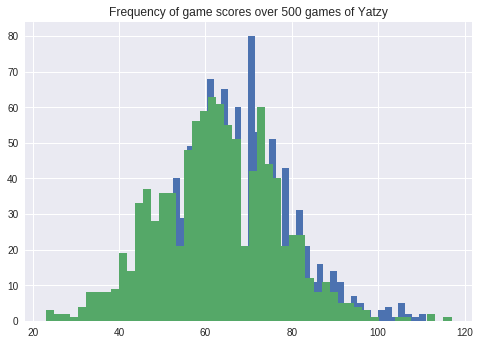

In [32]:
import matplotlib.pyplot as plt
plt.hist(game_scores_basic_player, bins=50)
plt.hist(game_scores_min_player, bins=50)
plt.title("Frequency of game scores over 500 games of Yatzy")
plt.show()

In [33]:
import numpy as np
print("Basic player")
print("Average score:", str(np.mean(game_scores_basic_player)))
print("Minimum score:", str(np.min(game_scores_basic_player)))
print("Maximum score:", str(np.max(game_scores_basic_player)))

print("Min player")
print("Average score:", str(np.mean(game_scores_min_player)))
print("Minimum score:", str(np.min(game_scores_min_player)))
print("Maximum score:", str(np.max(game_scores_min_player)))

Basic player
Average score: 67.778
Minimum score: 32
Maximum score: 111
Min player
Average score: 62.775
Minimum score: 23
Maximum score: 117


# Testing
Try some aspects of the game

Test if the player generates reasonable playable options

In [13]:
available_scores  = ['ONES', 'STRAIGHT', 'FIVES', 'PAIR', 'FULL_HOUSE', 'TRIPLETS', 'TWO_PAIR']
dice = [2,4,3,1,2]
player = Player()
player.choose_die(dice, available_scores)

[4, 3, 2, 1, 0]

Test the scoring

In [0]:
options = {
  "ONES": [
    {
      "dice": [
        1,
        1,
        1
      ]
    }
  ],
  "FIVES": [
    {
      "dice": []
    }
  ],
  "PAIR": [
    {
      "dice": [
        1,
        1
      ]
    }
  ],
  "FULL_HOUSE": [],
  "STRAIGHT": []
}

How scores are assigned

In [15]:

for scoring, option in options.items():
  print(scoring,option)  
  for dice_set in option:
    dice_set['score'] = sum(dice_set['dice'])
    
print(options)

ONES [{'dice': [1, 1, 1]}]
FIVES [{'dice': []}]
PAIR [{'dice': [1, 1]}]
FULL_HOUSE []
STRAIGHT []
{'ONES': [{'dice': [1, 1, 1], 'score': 3}], 'FIVES': [{'dice': [], 'score': 0}], 'PAIR': [{'dice': [1, 1], 'score': 2}], 'FULL_HOUSE': [], 'STRAIGHT': []}


In [16]:
score_option = list(options.keys())

random_option = random.randint(0, (len(score_option)-1))

chosen_score = score_option[random_option]

try: 
  options[chosen_score][0]['dice']
except:
  

SyntaxError: ignored

In [0]:
len(score_option)

Test the two pair generation

# Debugging / testing section

In [0]:
import matplotlib.pyplot as plt
plt.hist(scores)
plt.title("Frequency of Yatzee scores by players over 1000 games")
plt.show()

In [0]:
options = {
  "ONES": [
    {
      "dice": [1,1,1],
       "score" : 3
    }
  ],
  "FIVES": [
    {
      "dice": [],
        "score" : 0
    }
  ],
  "PAIR": [
    {
      "dice": [1,1],
       "score" : 10
    }
  ],
  "FULL_HOUSE": [
      
      {
        "dice" : [],
        "score" : 20
      },
      
      {
        "dice" : [],
        "score" : 3
      }
      
  ],
  "STRAIGHT": [
      {
      'dice' : [],
      'score' : 0
      }
      
  ]
}

In [0]:
non_zero = {
    outer_k: {inner_k: myfunc(inner_v)} 
    for k, v in options.items()
    for inner_k, inner_v in outer_v.items()
}


data = {
    outer_k: {inner_k: myfunc(inner_v)} 
    for outer_k, outer_v in outer_dict.items()
    for inner_k, inner_v in outer_v.items()
}

In [0]:
scoring_and_key = {}
for k,v in options.items():
  print(k,v)